In [1]:
!git clone https://github.com/HoanChan/TableVision.git TableVision

Cloning into 'TableVision'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 179 (delta 37), reused 80 (delta 20), pack-reused 81
Receiving objects: 100% (179/179), 215.54 MiB | 22.42 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (75/75), done.


In [2]:
!git clone https://github.com/microsoft/table-transformer Pubtables-1M

Cloning into 'Pubtables-1M'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 753 (delta 338), reused 383 (delta 304), pack-reused 321
Receiving objects: 100% (753/753), 356.09 KiB | 8.90 MiB/s, done.
Resolving deltas: 100% (466/466), done.


In [3]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 40.3 MB/s eta 0:00:00


In [4]:
def split_pth_file(input_file, output_file1, output_file2):
    with open(input_file, 'rb') as f:
        data = f.read()

    half_len = len(data) // 2

    with open(output_file1, 'wb') as f1, open(output_file2, 'wb') as f2:
        f1.write(data[:half_len])
        f2.write(data[half_len:])

def combine_pth_files(input_file1, input_file2, output_file):
    with open(input_file1, 'rb') as f1, open(input_file2, 'rb') as f2:
        data1 = f1.read()
        data2 = f2.read()

    combined_data = data1 + data2

    with open(output_file, 'wb') as f:
        f.write(combined_data)

In [5]:
combine_pth_files("/content/TableVision/models/pubtables1m_detection_detr_r18.pth_part1", "/content/TableVision/models/pubtables1m_detection_detr_r18.pth_part2", "/content/TableVision/models/pubtables1m_detection_detr_r18.pth")
combine_pth_files("/content/TableVision/models/pubtables1m_structure_detr_r18.pth_part1", "/content/TableVision/models/pubtables1m_structure_detr_r18.pth_part2", "/content/TableVision/models/pubtables1m_structure_detr_r18.pth")


In [6]:
import sys
# Thêm đường dẫn đến thư mục 'src' vào danh sách đường dẫn
# sys.path.append('/content/TableVision/')
sys.path.append('/content/Pubtables-1M/')
sys.path.append('/content/Pubtables-1M/src/')
sys.path.append('/content/Pubtables-1M/detr/')

from src.inference import TableExtractionPipeline

# Create inference pipeline
pipe = TableExtractionPipeline(det_config_path='/content/Pubtables-1M/src/detection_config.json',
                               det_model_path='/content/TableVision/models/pubtables1m_detection_detr_r18.pth', det_device='cpu',
                               str_config_path='/content/Pubtables-1M/src/structure_config.json',
                               str_model_path='/content/TableVision/models/pubtables1m_structure_detr_r18.pth', str_device='cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.7MB/s]


Detection model initialized.
Detection model weights loaded.
Structure model initialized.
Structure model weights loaded.


In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from src.inference import visualize_detected_tables, visualize_cells

def deleteFile(file_path):
  try:
      # Thực hiện xoá file
      import os
      os.remove(file_path)
      print(f"{file_path} đã được xoá thành công.")
  except FileNotFoundError:
      print(f"File {file_path} không tồn tại.")
  except Exception as e:
      print(f"Lỗi khi xoá file {file_path}: {e}")

def crop(img, bbox, margin = 10, padding = 20):
  # Tạo ảnh mới có kích thước lớn hơn để chứa ảnh cũ và padding
  crop_img = img.crop((bbox[0] - margin, bbox[1] - margin, bbox[2] + margin, bbox[3] + margin))
  new_width = crop_img.width + 2 * padding
  new_height = crop_img.height + 2 * padding
  # Tạo ảnh mới với kích thước lớn hơn
  new_img = Image.new("RGB", (new_width, new_height), (255, 255, 255))  # Màu nền trắng, bạn có thể thay đổi nếu muốn
  # Đặt ảnh cũ vào vị trí giữa ảnh mới
  new_img.paste(crop_img, (padding, padding))
  return new_img

def detectTable(pipe, img_path):
  img = Image.open(img_path)
  tokens = {}
  extracted_tables = pipe.detect(img)
  print(extracted_tables)
  visualize_detected_tables(img, extracted_tables['objects'], "/content/0.jpg")
  img_tables = Image.open("/content/0.jpg")
  img_data = [(img, img_tables)]
  for index, objects in enumerate(extracted_tables['objects']):
    bbox = objects['bbox']
    cropped_img = crop(img, bbox, 10, 20)
    extracted_cell = pipe.recognize(cropped_img, tokens, out_objects=True, out_cells=True, out_html=True, out_csv=True)
    cells = extracted_cell['cells']
    csv = extracted_cell['csv']
    html = extracted_cell['html']
    visualize_cells(cropped_img, cells[0], "/content/2.jpg")
    img_cell = Image.open('/content/2.jpg')
    img_data += [(cropped_img, img_cell)]

  num_img = 1 + len(extracted_tables)

  plt.figure(figsize=(10, 5*num_img))
  plot_size = num_img * 100 + 20
  for index, imgs in enumerate(img_data):
    img1, img2 = imgs
    plt.subplot(plot_size + index * 2 + 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')
    plt.subplot(plot_size + index * 2 + 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')

  plt.show()
  deleteFile("/content/0.jpg")
  deleteFile("/content/1.jpg")
  deleteFile("/content/2.jpg")


In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from src.inference import visualize_detected_tables, visualize_cells

def deleteFile(file_path):
  try:
      # Thực hiện xoá file
      import os
      os.remove(file_path)
      print(f"{file_path} đã được xoá thành công.")
  except FileNotFoundError:
      print(f"File {file_path} không tồn tại.")
  except Exception as e:
      print(f"Lỗi khi xoá file {file_path}: {e}")

def crop(img, bbox, margin = 10, padding = 20):
  # Tạo ảnh mới có kích thước lớn hơn để chứa ảnh cũ và padding
  crop_img = img.crop((bbox[0] - margin, bbox[1] - margin, bbox[2] + margin, bbox[3] + margin))
  new_width = crop_img.width + 2 * padding
  new_height = crop_img.height + 2 * padding
  # Tạo ảnh mới với kích thước lớn hơn
  new_img = Image.new("RGB", (new_width, new_height), (255, 255, 255))  # Màu nền trắng, bạn có thể thay đổi nếu muốn
  # Đặt ảnh cũ vào vị trí giữa ảnh mới
  new_img.paste(crop_img, (padding, padding))
  return new_img

def detectTable(pipe, img_path):
  img = Image.open(img_path)
  tokens = {}
  extracted_tables = pipe.detect(img)
  print(extracted_tables)
  visualize_detected_tables(img, extracted_tables['objects'], "/content/0.jpg")
  img_tables = Image.open("/content/0.jpg")
  img_data = [(img, img_tables)]
  cellsDatas = []
  for index, objects in enumerate(extracted_tables['objects']):
    bbox = objects['bbox']
    cropped_img = crop(img, bbox, 10, 20)
    extracted_cell = pipe.recognize(cropped_img, tokens, out_objects=True, out_cells=True, out_html=True, out_csv=True)
    cells = extracted_cell['cells']
    csv = extracted_cell['csv']
    html = extracted_cell['html']
    visualize_cells(cropped_img, cells[0], "/content/2.jpg")
    img_cell = Image.open('/content/2.jpg')
    img_data += [(cropped_img, img_cell)]
    cellsDatas += [(cropped_img, extracted_cell)]

  num_img = 1 + len(img_data)

  plt.figure(figsize=(10, 5*num_img))
  plot_size = num_img * 100 + 20
  for index, imgs in enumerate(img_data):
    img1, img2 = imgs
    plt.subplot(plot_size + index * 2 + 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')
    plt.subplot(plot_size + index * 2 + 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')

  plt.show()
  deleteFile("/content/0.jpg")
  deleteFile("/content/1.jpg")
  deleteFile("/content/2.jpg")
  return cellsDatas


{'objects': [{'label': 'table', 'score': 0.9999252557754517, 'bbox': [69.23287963867188, 68.56936645507812, 1064.202392578125, 640.3823852539062]}]}


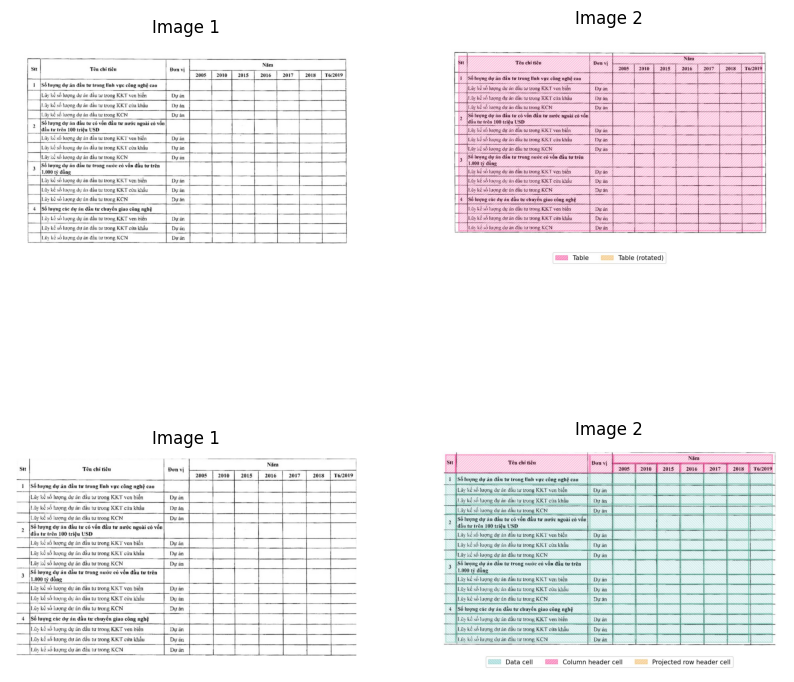

/content/0.jpg đã được xoá thành công.
File /content/1.jpg không tồn tại.
/content/2.jpg đã được xoá thành công.


In [9]:
cellsDatas = detectTable(pipe, "/content/TableVision/sample/vn1.jpg")

{'objects': [{'label': 'table', 'score': 0.9998012185096741, 'bbox': [21.200448989868164, 45.51913833618164, 653.7256469726562, 281.71295166015625]}]}


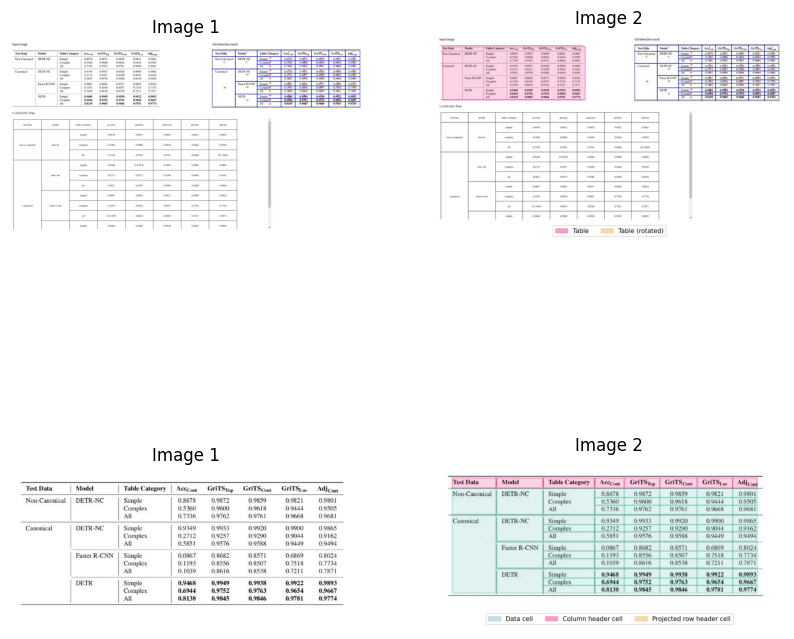

/content/0.jpg đã được xoá thành công.
File /content/1.jpg không tồn tại.
/content/2.jpg đã được xoá thành công.


[(<PIL.Image.Image image mode=RGB size=693x296>,
  {'objects': [{'label': 'table row',
     'score': 0.9979263544082642,
     'bbox': [29.50661849975586,
      136.6773223876953,
      643.3056030273438,
      156.05096435546875],
     'column header': False},
    {'label': 'table row',
     'score': 0.9975042939186096,
     'bbox': [29.50661849975586,
      229.4923858642578,
      643.3056030273438,
      244.80801391601562],
     'column header': False},
    {'label': 'table row',
     'score': 0.9958819150924683,
     'bbox': [29.50661849975586,
      83.57496643066406,
      643.3056030273438,
      102.9207534790039],
     'column header': False},
    {'label': 'table column',
     'score': 0.9999527931213379,
     'bbox': [447.2381896972656,
      29.04596519470215,
      521.9181518554688,
      260.1622619628906]},
    {'label': 'table column',
     'score': 0.9999727010726929,
     'bbox': [316.4874267578125,
      29.04596519470215,
      374.7879333496094,
      260.1622619

In [11]:
# detectTable(pipe, "/content/TableVision/sample/tablex3.png")
original_image = Image.open("/content/TableVision/sample/tablex3.png")
original_image.convert('RGB').save("new_image.jpg", 'JPEG')
detectTable(pipe, "/content/new_image.jpg")

In [12]:
! pip install --quiet vietocr==0.3.12

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 99.8 MB/s eta 0:00:00


In [13]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [14]:
config = Cfg.load_config_from_name('vgg_seq2seq')

In [15]:
# config['weights'] = './weights/transformerocr.pth'
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cpu'
config['predictor']['beamsearch']=False

In [16]:
detector = Predictor(config)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
10935it [00:05, 2089.51it/s]


In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def display_bbox(image, cells):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for index, cell in enumerate(cells):
        bbox = cell['bbox']
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        text_x = (bbox[0] + bbox[2]) / 2
        text_y = (bbox[1] + bbox[3]) / 2
        ax.text(text_x, text_y, str(index), color='r', ha='center', va='center')

    plt.show()


In [19]:
def sort_cells_by_position(cells):
    for a_cells in cells:
      yield sorted(a_cells, key=lambda x: (x['bbox'][1], x['bbox'][0]))

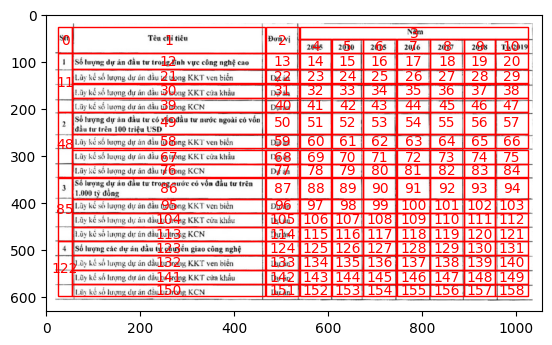

In [20]:
import cv2
import numpy
cells_imgs = []
for img, extracted_cell in cellsDatas:
    cells = extracted_cell['cells']
    # csv = extracted_cell['csv']
    # html = extracted_cell['html']
    # display_bbox(img, cells)
    image = cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)
    # print(cells)
    for cell in sort_cells_by_position(cells):
      display_bbox(img, cell)
      for bbox in cell:
        x1, y1, x2, y2 = bbox['bbox']
        cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
        cells_imgs += [(cropped_image, bbox)]
        # print(bbox)

'Số lượng dự án đầu tư có vốn đầu tư nước ngoài có vốn'

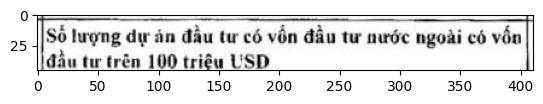

In [21]:
pil_image = Image.fromarray(cv2.cvtColor(cells_imgs[49][0], cv2.COLOR_BGR2RGB))
plt.imshow(pil_image)
s = detector.predict(pil_image)
s

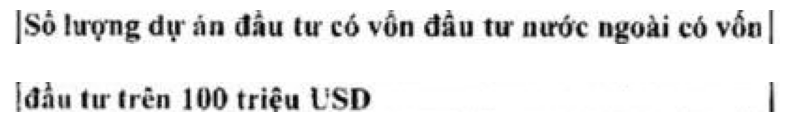

In [84]:
import cv2
import numpy as np

def display_lines(lines):
    num_lines = len(lines)
    fig, axes = plt.subplots(num_lines, 1, figsize=(8, num_lines))
    for i, line in enumerate(lines):
        axes[i].imshow(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def process_image(image):
    gray = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    _, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    eroded = cv2.erode(bw, kernel2, iterations=1) # Bỏ đường thẳng đứng
    dilated = cv2.dilate(eroded, kernel, iterations=10) # mở rộng để lấp đầy hàng

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    images = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        if area > 100 and w > h and h > 5:
            # cv2.drawContours(images, contours, -1, (0, w%255, 0), 2)
            cropped = image[y-3:y+h+3, x:]
            images+=[cropped]
    return images[::-1]

lines = process_image(cells_imgs[49][0])
display_lines(lines)

In [85]:
text = '\n'.join(map(lambda x: detector.predict(Image.fromarray(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))), lines))
print(text)

Số lượng dự ản đầu tư có vốn đầu tư nước ngoài có vốn
đầu tư trên 100 triệu USD
